# 目次

- データ確認
- データ結合
- 目的変数との関係性を確認
- 数値変換
  1. 対数変換
  2. ウィンザー化
  3. Box-Cox変換

# ライブラリ群

In [1]:
# データ処理
import csv
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.0f}'.format

# 描画
import matplotlib.pyplot as plt
import matplotlib.style as mplstyle
import japanize_matplotlib
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_style(style='dark')
from tqdm import tqdm # プログレスバー
mplstyle.use('fast')

# 表示調整
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
# 日本語対応
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'Noto Sans CJK JP']
# サイズ調整
plt.rcParams["font.size"] = 10 # 文字サイズ
plt.rcParams["figure.figsize"] = [20,5] # 表示サイズ
# HTML対応
from IPython.core.display import display, HTML
# 全表示対応
display(HTML("<style>.cm-s-ipython span.cm-comment { color: blue; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

# データ確認

In [2]:
user_table = pd.read_csv("./user_table.csv")
tran_AtoI = pd.read_csv("./historical_transactions_AtoI.csv")
tran_X = pd.read_csv("./historical_transactions_X.csv")

In [3]:
user_table.head()
user_table.shape

,user_id,name,nickname,age,country,num_family,married,job,income,profile
0,14742,Richard Chen,kathryn77,20,NaN,1,0,Human resources officer,394,Last sit star physical accept. Actually relate...
1,21530,Kayla Garcia,brandtalexander,59,Saint Kitts and Nevis,4,0,"Teacher, early years/pre",370,Door entire as. Whose suddenly mission hold.\n...
2,34985,Troy Blackwell,richardfarmer,44,Iraq,3,2,Forensic psychologist,326,Writer drug a tax. Team standard both write pr...
3,31854,Suzanne Ray,nicole40,52,Sri Lanka,nan,0,Garment/textile technologist,673,Evidence try next degree man local. Movie sea ...
4,46689,Susan Horn,heather38,nan,Japan,1,0,Nature conservation officer,306,Voice after assume hard tonight. Recent try ma...


(50103, 10)

In [4]:
tran_AtoI.head()
tran_AtoI.shape

,user_id,price,num_purchase,item
0,0,867,3,C
1,0,947,2,F
2,0,815,2,D
3,0,867,3,C
4,1,172,2,B


(169379, 4)

In [5]:
tran_X.shape
tran_X.head()

(6444, 4)

,user_id,price,num_purchase,item
0,1,137,1,X
1,7,137,1,X
2,9,137,1,X
3,19,137,1,X
4,21,137,1,X


In [6]:
# レコード件数比較用の関数
def show_graph(labels, records, color, va):
    graph = plt.bar(labels, records, color=color)

    def autolabel(graph):
        for rect in graph:
            labels = rect.get_height()
            plt.annotate('{}'.format(labels),
                xy=(rect.get_x() + rect.get_width() / 2, labels),
                xytext=(0, 4),
                textcoords="offset points",
                ha='center', va=va)

    plt.grid()
    autolabel(graph);

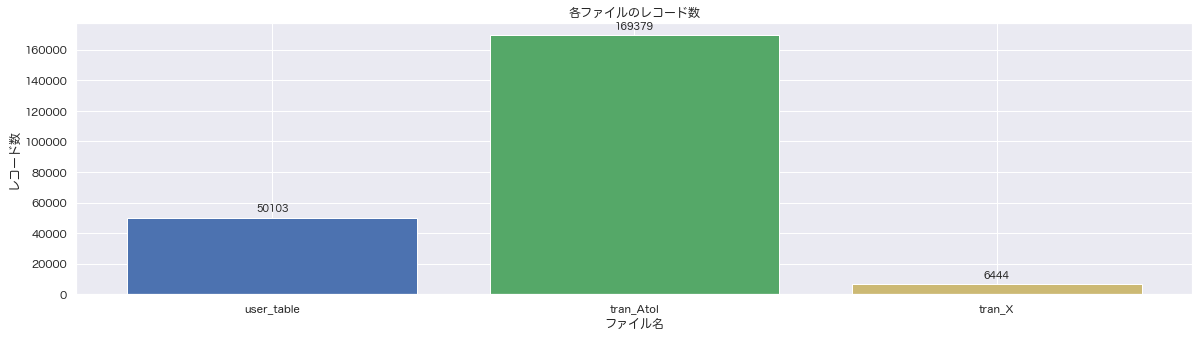

In [7]:
# レコード件数をプロット
x1=len(user_table)
x2=len(tran_AtoI)
x3=len(tran_X)
records=[x1,x2,x3]
labels=['user_table','tran_AtoI','tran_X']
color=['b','g','y']
va='bottom'

plt.title('各ファイルのレコード数')
plt.xlabel('ファイル名')
plt.ylabel('レコード数')
show_graph(labels, records, color, va);

# データ結合

In [31]:
# 結合（UNION）
print(f'tran_AtoIのレコード数: {tran_AtoI.shape[0]}') # df1
print(f'tran_Xのレコード数: {tran_X.shape[0]}') # df2
print('='*25)
print(f'合計レコード数(予定): {tran_AtoI.shape[0] + tran_X.shape[0]}') # df1+ df2

train_AtoX=tran_AtoI.append(tran_X, ignore_index=True)
print(f'合計レコード数（結果）: {train_AtoX.shape[0]}') # df1+ df2

train_all = train_AtoX.copy()
train_all['target'] = 0
train_all = train_all.where(train_all['item'] != 'X', 1) # item='X'：正例

# 目的変数（件数）
train_all['target'].value_counts()

tran_AtoIのレコード数: 169379
tran_Xのレコード数: 6444
合計レコード数(予定): 175823
合計レコード数（結果）: 175823


0    169379
1      6444
Name: target, dtype: int64

In [38]:
# 結合（Left join）
train = pd.merge(train_all, user_table, on='user_id', how='left')
train.head()

,user_id,price,num_purchase,item,target,name,nickname,age,country,num_family,married,job,income,profile
0,0,867,3,C,0,Norma Fisher,vchang,18,Japan,3,1,Public affairs consultant,1034,American whole magazine truth stop whose. On t...
1,0,947,2,F,0,Norma Fisher,vchang,18,Japan,3,1,Public affairs consultant,1034,American whole magazine truth stop whose. On t...
2,0,815,2,D,0,Norma Fisher,vchang,18,Japan,3,1,Public affairs consultant,1034,American whole magazine truth stop whose. On t...
3,0,867,3,C,0,Norma Fisher,vchang,18,Japan,3,1,Public affairs consultant,1034,American whole magazine truth stop whose. On t...
4,1,172,2,B,0,Jorge Sullivan,williamsullivan,21,Egypt,2,1,Energy engineer,nan,Language ball floor meet usually board necessa...


In [41]:
# 欠損値確認
missing_values = pd.DataFrame()
for column in train.columns:
    missing_values[column] = [train[train[column].isnull()].shape[0]]
missing_values.T

,0
user_id,0
price,0
num_purchase,0
item,0
target,0
name,0
nickname,0
age,17303
country,34448
num_family,8632


# 目的変数との関係性の確認

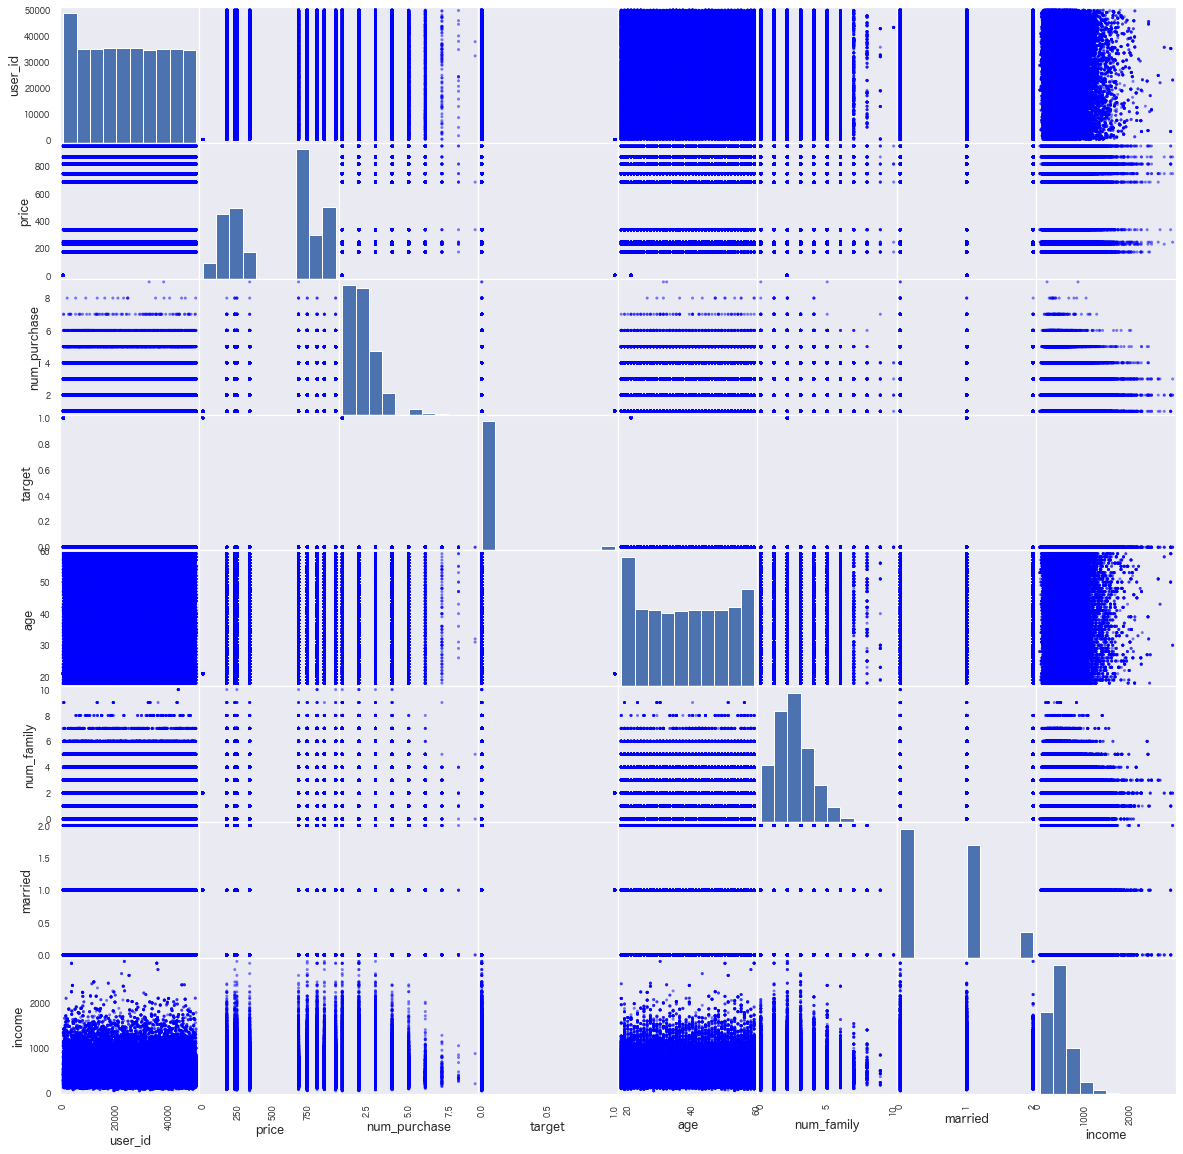

In [75]:
# 散布図行列
pd.plotting.scatter_matrix(train, c='blue', figsize=(20, 20))
plt.show();

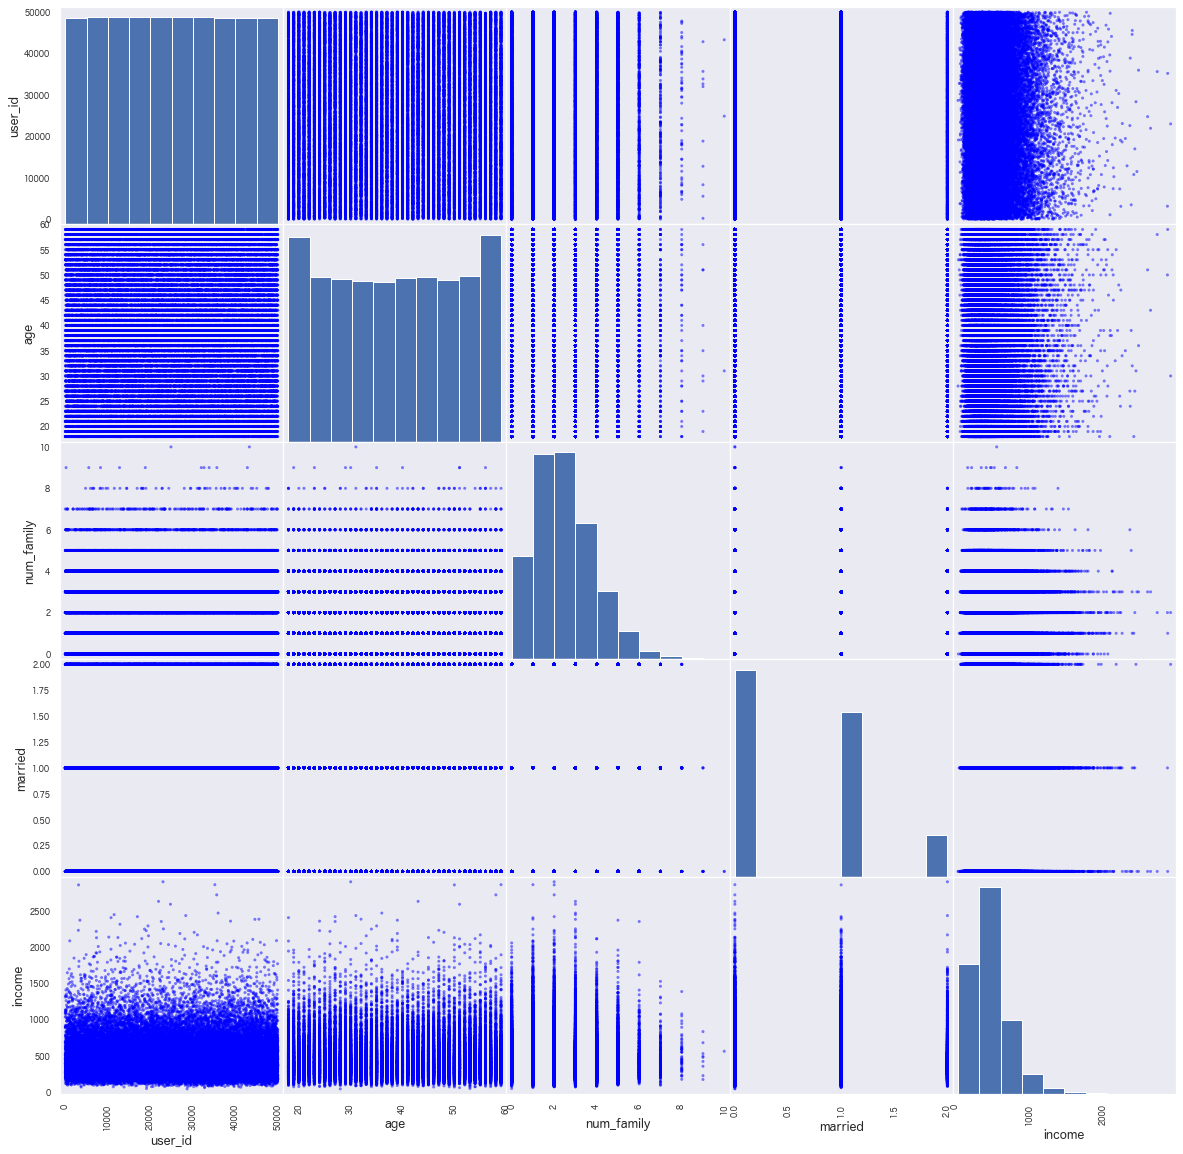

In [88]:
# 散布図行列
pd.plotting.scatter_matrix(user_table, c='blue', figsize=(20, 20))
plt.show();

In [72]:
#　線形関係の確認
def target_relation(tgt, data):
    y_train = data[tgt]

    # ヒートマップの表示数
    k = len(data.columns) - 1
    fig = plt.figure(figsize=(20,20))

    # 各変数間の相関係数
    corrmat = data.corr()

    # リストの最大値から順にk個の要素を取得
    cols = corrmat.nlargest(k, tgt)[tgt].index

    # 全て可視化
    for i in np.arange(1, k):
        X_train = data[cols[i]]
        ax = fig.add_subplot(5,4, i)
        sns.regplot(x=X_train, y=y_train)
    
    plt.tight_layout()
    plt.show();

In [74]:
tgt = 'target' # 目的変数
columns = ['user_id', 'price', 'num_purchase', 'item', 'target', 'name', 'nickname', 'job', 'profile'] # 対象項目
target_relation(tgt, traicolumnmns])

# 数値変換

## 対数変換

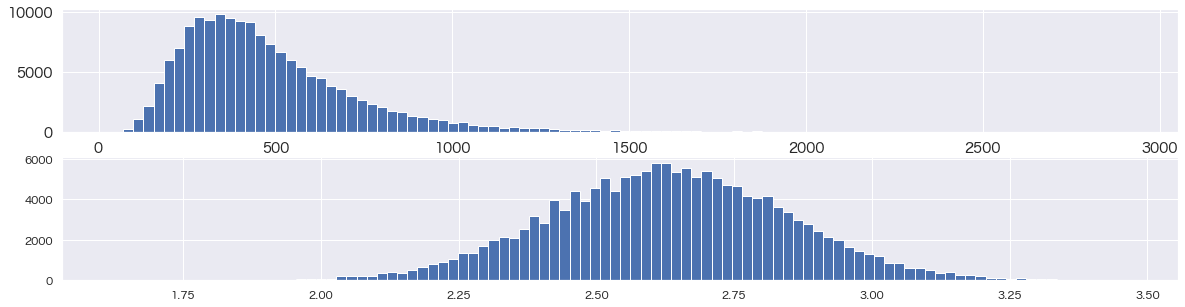

In [87]:
tgt_name = 'income'
log_tgt_name ='log_income'
# 対数変換
train_log = train.copy()
train_log[log_tgt_name] = np.log10(train[tgt_name] + 1)

fig, (ax1, ax2) = plt.subplots(2, 1)
train_log[tgt_name].hist(ax=ax1, bins=100)
ax1.tick_params(labelsize=14)
ax1.set_xlabel('')
ax1.set_ylabel('')

train_log[log_tgt_name].hist(ax=ax2, bins=100)
ax1.tick_params(labelsize=14)
ax1.set_xlabel('')
ax1.set_ylabel('');

## ウィンザー化

In [94]:
# パーセンタイルの取得
tgt = 'income'
df = user_table.copy()
Q1 = df[tgt].quantile(.25) # 25%
Q3 = df[tgt].quantile(.75) # 第三位分位

# 閾値の算出
IQR = Q3 - Q1
IQR

# 四分位範囲（IQR）の1.5倍以上以下を外れ値とする
threshold = Q3 + 1.5 * IQR
threshold

# 外れ値の検出
df_outlier = df[df[tgt].apply(lambda x:x > threshold)]
df_outlier[[tgt]].head()

292.0

1036.0

,income
9,1697
25,1152
43,1080
46,1347
68,1084


## Box-Cox変換

In [130]:
from scipy import stats

def box_cox(df, tgt, lmbda):
    df = train.copy()

    tgt = tgt
    bxcx = df.copy()

    tgt_log = stats.boxcox(bxcx[tgt], lmbda=lmbda) # 分布の指定
    # lmbda=0 : 対数変換（縮小化）
    # lmbda=0.5 : 平方根変換（縮小化）
    # lmbda=1以上 : 拡大化

    tgt_bc, tgt_params = stats.boxcox(bxcx[tgt]) # 0, 負数を扱えない
    tgt_params
    
    bxcx['tgt_log'] = tgt_log
    bxcx['tgt_bc'] = tgt_bc

    fig, (ax1, ax2, ax3) = plt.subplots(3,1)

    bxcx[tgt].hist(ax=ax1, bins=100, figsize=[20, 15])
    ax1.set_yscale('log')
    ax1.tick_params(labelsize=14)
    ax1.set_title(f'{tgt}のヒストグラム')

    bxcx['tgt_log'].hist(ax=ax2, bins=100, figsize=[20, 15])
    ax2.set_yscale('log')
    ax2.tick_params(labelsize=14)
    ax2.set_title(f'{tgt}のヒストグラム（対数変換後）')

    bxcx['tgt_bc'].hist(ax=ax3, bins=100, figsize=[20, 15]);
    ax3.set_yscale('log')
    ax3.tick_params(labelsize=14)
    ax3.set_title(f'{tgt}のヒストグラム（最適なbox-cox変換後）');

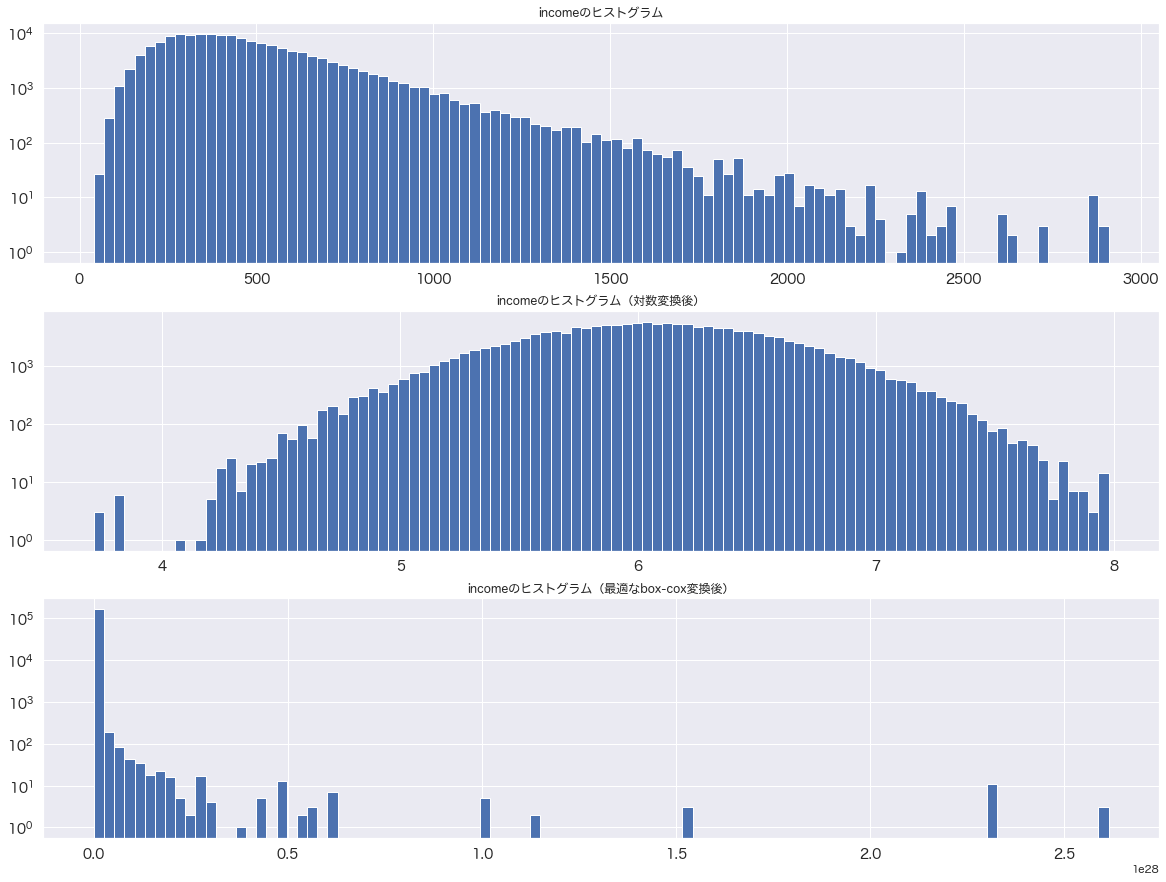

In [131]:
tgt = 'income'
lmbda = 0
box_cox(df, tgt, lmbda)

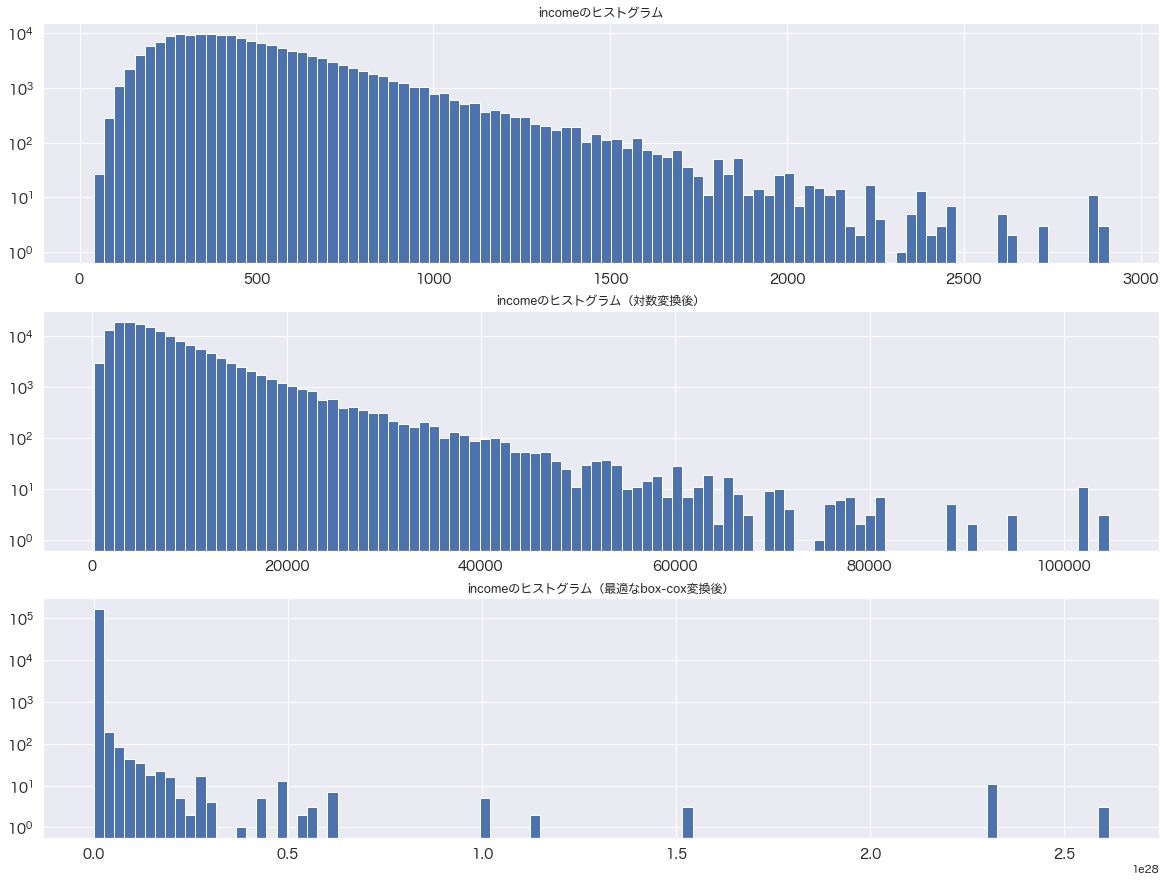

In [132]:
tgt = 'income'
lmbda = 1.5
box_cox(df, tgt, lmbda)

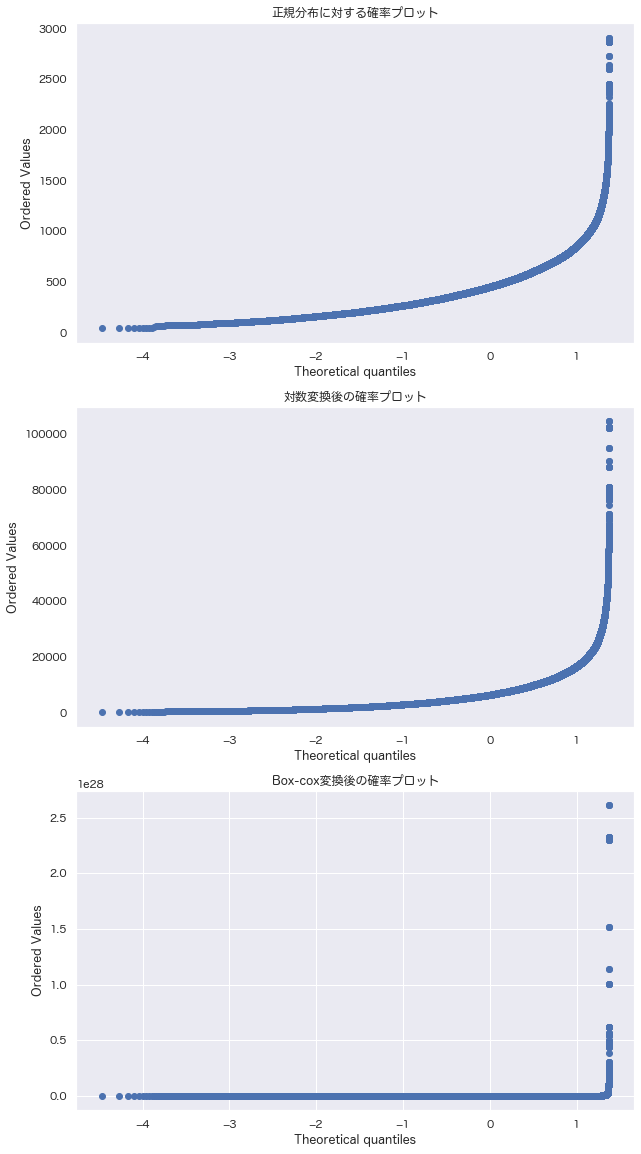

In [127]:
# 確率プロット
fig2, (ax1, ax2, ax3) = plt.subplots(3,1)

plt.rcParams["figure.figsize"] = [10,20] # 表示サイズ
prob1 = stats.probplot(bxcx[tgt], dist=stats.norm, plot=ax1)
ax1.set_title('正規分布に対する確率プロット')

prob2 = stats.probplot(bxcx['tgt_log'], dist=stats.norm, plot=ax2)
ax2.set_title('対数変換後の確率プロット')

prob3 = stats.probplot(bxcx['tgt_bc'], dist=stats.norm, plot=ax3)
ｐlt.grid()
ax3.set_title('Box-cox変換後の確率プロット');

In [ ]:
plt.rcParams["figure.figsize"] = [20,5] # 表示サイズ